Access Dataset from Google Drive

In [36]:
from google.colab import drive

drive.mount('/content/drive')

data_dir = "/content/drive/MyDrive/Colab Notebooks/Data"
print(f"Dataset directory: {data_dir}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Dataset directory: /content/drive/MyDrive/Colab Notebooks/Data


 Importing Libraries and Dependencies

In [37]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np
from torchvision import datasets

Load Dataset & DataLoader

In [38]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_dataset = datasets.ImageFolder(root=f"{data_dir}/train", transform=transform)
val_dataset = datasets.ImageFolder(root=f"{data_dir}/val", transform=transform)
test_dataset = datasets.ImageFolder(root=f"{data_dir}/test", transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

Data Augmentation

In [39]:
# # Path ke dataset
# DATA_DIR = "/content/drive/MyDrive/Colab Notebooks/Data"

# # Transformasi dengan augmentasi khusus untuk citra OCT makula mata
# transform = transforms.Compose([
#     transforms.RandomHorizontalFlip(p=0.5),  # Membalik gambar secara horizontal dengan probabilitas 50%
#     transforms.RandomRotation(10),  # Rotasi kecil hingga 10 derajat
#     transforms.ColorJitter(brightness=0.1, contrast=0.1),  # Variasi brightness & contrast ringan
#     transforms.GaussianBlur(kernel_size=(3, 3)),  # Menambahkan blur ringan untuk meningkatkan ketahanan model
#     transforms.RandomResizedCrop(224, scale=(0.9, 1.0)),  # Crop kecil agar tetap sesuai
#     transforms.ToTensor(),  # Konversi ke tensor
#     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalisasi
# ])

# # Load dataset dengan transformasi augmentasi
# dataset = datasets.ImageFolder(root=f"{DATA_DIR}/train", transform=transform)
# data_loader = DataLoader(dataset, batch_size=16, shuffle=True)

# # Fungsi untuk menampilkan beberapa gambar hasil augmentasi
# def show_augmented_images(data_loader):
#     images, labels = next(iter(data_loader))
#     fig, axes = plt.subplots(2, 8, figsize=(12, 5))
#     for i, ax in enumerate(axes.flat):
#         img = images[i].permute(1, 2, 0).numpy()
#         img = img * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]  # Denormalisasi
#         img = img.clip(0, 1)
#         ax.imshow(img)
#         ax.axis('off')
#     plt.show()

# # Menampilkan hasil augmentasi
# show_augmented_images(data_loader)

Implementasi Model Transfer Learning Arsitektur VGG19

In [40]:
model = torchvision.models.vgg19(weights=torchvision.models.VGG19_Weights.DEFAULT)

 Inisiasi Parameter Pengujian Fine-Tuning & Freezing Layer

In [41]:
# Pilihan Fine-Tuning (True = Fine-Tuning, False = Freezing Layer)
fine_tuning = True  # Ubah ke False jika ingin membekukan semua layer kecuali classifier

# Konfigurasi Fine-Tuning / Freezing Layer
if fine_tuning:
    print("Fine-Tuning Mode: Semua layer fitur diaktifkan untuk training.")
    for param in model.features.parameters():
        param.requires_grad = True  # Semua layer fitur dapat dilatih
else:
    print("Freezing Mode: Membekukan semua layer fitur, hanya classifier yang dilatih.")
    for param in model.features.parameters():
        param.requires_grad = False  # Membekukan layer fitur

    # Hanya classifier yang dilatih
    for param in model.classifier.parameters():
        param.requires_grad = True

# Menyesuaikan jumlah kelas untuk klasifikasi (4 kelas)
num_classes = 4
# Sesuaikan layer pertama dengan output feature extractor (misalnya 25088 untuk VGG16)
model.classifier = nn.Sequential(
    nn.Linear(in_features=25088, out_features=4096),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(in_features=4096, out_features=1024),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(in_features=1024, out_features=num_classes)
)
# Menjalankan model di GPU jika tersedia
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
# Loss function
criterion = nn.CrossEntropyLoss()
# Optimizer hanya akan memperbarui parameter yang memiliki requires_grad=True
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.000005, weight_decay=1e-4)
# Scheduler untuk menurunkan lr saat validation loss stagnan
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2, verbose=True)


Fine-Tuning Mode: Semua layer fitur diaktifkan untuk training.


In [42]:
# #MENURUNKAN LR JIKA validation loss stagnan
# from tensorflow.keras.callbacks import ReduceLROnPlateau
# reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1)

 Train dan Validation Function serta Menampilkan Proses Training Model VGG19

Epoch 1: 100%|██████████| 100/100 [01:33<00:00,  1.07it/s, loss=0.867]


Train Loss: 0.8671 | Train Accuracy: 0.6694
Validation Loss: 0.3183 | Validation Accuracy: 0.8875


Epoch 2: 100%|██████████| 100/100 [01:26<00:00,  1.16it/s, loss=0.229]


Train Loss: 0.2286 | Train Accuracy: 0.9191
Validation Loss: 0.1820 | Validation Accuracy: 0.9325


Epoch 3: 100%|██████████| 100/100 [01:26<00:00,  1.15it/s, loss=0.13]


Train Loss: 0.1303 | Train Accuracy: 0.9553
Validation Loss: 0.1741 | Validation Accuracy: 0.9363


Epoch 4: 100%|██████████| 100/100 [01:26<00:00,  1.16it/s, loss=0.0772]


Train Loss: 0.0772 | Train Accuracy: 0.9734
Validation Loss: 0.1528 | Validation Accuracy: 0.9425


Epoch 5: 100%|██████████| 100/100 [01:26<00:00,  1.16it/s, loss=0.0446]


Train Loss: 0.0446 | Train Accuracy: 0.9875
Reducing learning rate to 2.5e-06
Validation Loss: 0.1507 | Validation Accuracy: 0.9525


Epoch 6: 100%|██████████| 100/100 [01:26<00:00,  1.16it/s, loss=0.0193]


Train Loss: 0.0193 | Train Accuracy: 0.9956
Reducing learning rate to 1.25e-06
Validation Loss: 0.1526 | Validation Accuracy: 0.9463


Epoch 7: 100%|██████████| 100/100 [01:25<00:00,  1.16it/s, loss=0.0135]


Train Loss: 0.0135 | Train Accuracy: 0.9969
Reducing learning rate to 6.25e-07
Validation Loss: 0.1502 | Validation Accuracy: 0.9463


Epoch 8: 100%|██████████| 100/100 [01:25<00:00,  1.16it/s, loss=0.0108]


Train Loss: 0.0108 | Train Accuracy: 0.9988
Reducing learning rate to 3.125e-07
Validation Loss: 0.1530 | Validation Accuracy: 0.9500


Epoch 9: 100%|██████████| 100/100 [01:25<00:00,  1.16it/s, loss=0.00908]


Train Loss: 0.0091 | Train Accuracy: 0.9984
Reducing learning rate to 1.5625e-07
Validation Loss: 0.1531 | Validation Accuracy: 0.9463


Epoch 10: 100%|██████████| 100/100 [01:26<00:00,  1.16it/s, loss=0.00954]


Train Loss: 0.0095 | Train Accuracy: 0.9975
Reducing learning rate to 7.8125e-08
Validation Loss: 0.1537 | Validation Accuracy: 0.9450


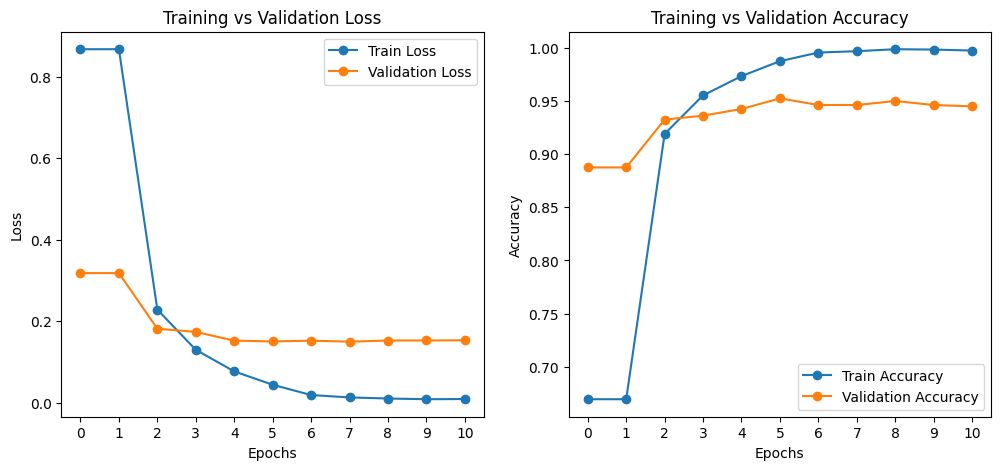

In [43]:
from tqdm import tqdm  # Import tqdm untuk progress bar
import torch.nn as nn
import torch.optim as optim

def train(model, device, train_loader, optimizer, criterion, epoch):
    model.train()  # Set model ke mode training
    running_loss = 0.0
    correct = 0
    total_samples = len(train_loader.dataset)

    tk0 = tqdm(train_loader, total=len(train_loader), desc=f"Epoch {epoch}")

    for batch_idx, (data, target) in enumerate(tk0):
        data, target = data.to(device), target.to(device)  # Memindahkan data ke GPU jika tersedia
        optimizer.zero_grad()  # Reset gradien optimizer
        output = model(data)  # Forward pass
        loss = criterion(output, target)  # Hitung loss
        loss.backward()  # Backpropagation
        optimizer.step()  # Update bobot model

        preds = torch.argmax(output, dim=1)  # Ambil kelas dengan probabilitas tertinggi
        correct += torch.sum(preds == target).item()
        running_loss += loss.item()

        tk0.set_postfix(loss=running_loss / (batch_idx + 1))  # Menampilkan loss secara real-time

    epoch_loss = running_loss / len(train_loader)  # Hitung rata-rata loss
    epoch_acc = correct / total_samples  # Hitung akurasi
    print(f"Train Loss: {epoch_loss:.4f} | Train Accuracy: {epoch_acc:.4f}")

    # Jika akurasi melebihi 0.98, kurangi learning rate untuk menghindari overfitting
    if epoch_acc >= 0.98:
        for param_group in optimizer.param_groups:
            param_group['lr'] *= 0.5  # Kurangi learning rate agar model tidak overfitting
        print(f"Reducing learning rate to {param_group['lr']}")

    return epoch_loss, epoch_acc

def validate(model, device, val_loader, criterion):
    model.eval()  # Set model ke mode evaluasi
    val_loss = 0.0
    correct = 0
    total_samples = len(val_loader.dataset)

    with torch.no_grad():  # Tidak perlu menghitung gradien saat validasi
        for data, target in val_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = criterion(output, target)
            val_loss += loss.item()
            preds = torch.argmax(output, dim=1)
            correct += torch.sum(preds == target).item()

    val_loss /= len(val_loader)
    val_acc = correct / total_samples
    print(f"Validation Loss: {val_loss:.4f} | Validation Accuracy: {val_acc:.4f}")
    return val_loss, val_acc

# Melatih model dan mencatat hasilnya
num_epochs = 10
train_losses, val_losses = [], []
train_accs, val_accs = [], []

# # Inisialisasi Early Stopping
# best_val_loss = float('inf')
# early_stop_counter = 0
# early_stop_patience = 3  # Hentikan training jika val_loss tidak membaik dalam 3 epoch

for epoch in range(1, num_epochs + 1):
    train_loss, train_acc = train(model, device, train_loader, optimizer, criterion, epoch)
    val_loss, val_acc = validate(model, device, val_loader, criterion)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)
    scheduler.step(val_loss)  # Update learning rate jika diperlukan

    # # Early Stopping
    # if val_loss < best_val_loss:
    #     best_val_loss = val_loss
    #     early_stop_counter = 0  # Reset counter jika val_loss membaik
    # else:
    #     early_stop_counter += 1
    #     print(f"Early stopping counter: {early_stop_counter}/{early_stop_patience}")
    #     if early_stop_counter >= early_stop_patience:
    #         print("Early stopping triggered. Stopping training.")
    #         break

# Menampilkan grafik loss dan akurasi
plt.figure(figsize=(12, 5))

# Grafik Loss
plt.subplot(1, 2, 1)
plt.plot([0] + list(range(1, num_epochs + 1)), [train_losses[0]] + train_losses, label='Train Loss', marker='o')
plt.plot([0] + list(range(1, num_epochs + 1)), [val_losses[0]] + val_losses, label='Validation Loss', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.xticks(range(0, num_epochs + 1))  # Memastikan sumbu x dimulai dari 0
plt.legend()
plt.title('Training vs Validation Loss')

# Grafik Akurasi
plt.subplot(1, 2, 2)
plt.plot([0] + list(range(1, num_epochs + 1)), [train_accs[0]] + train_accs, label='Train Accuracy', marker='o')
plt.plot([0] + list(range(1, num_epochs + 1)), [val_accs[0]] + val_accs, label='Validation Accuracy', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.xticks(range(0, num_epochs + 1))  # Memastikan sumbu x dimulai dari 0
plt.legend()
plt.title('Training vs Validation Accuracy')

plt.show()


Evaluasi Model dengan Confusion Matrix

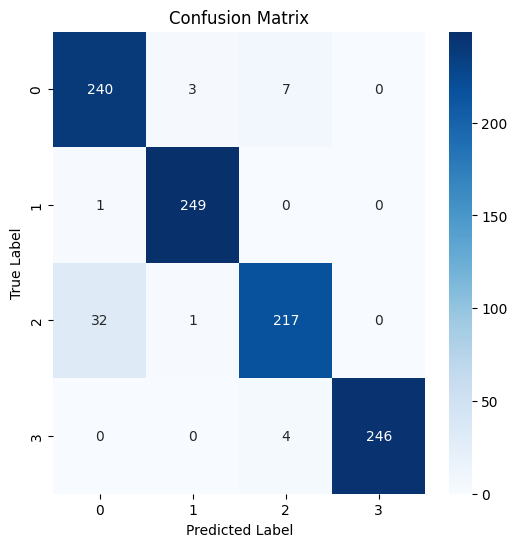

In [44]:
def evaluate(model, device, test_loader):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            preds = torch.argmax(output, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(target.cpu().numpy())
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(num_classes), yticklabels=range(num_classes))
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

evaluate(model, device, test_loader)

In [45]:
# !pip install streamlit